In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import json

In [3]:
train_df = pd.read_csv(r'/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/processed/train.csv')
train_df

,id,date,online_hours
0,111556,2017-05-31,2.2
1,111556,2017-06-01,2.5
2,111556,2017-06-02,0.0
3,111556,2017-06-03,0.0
4,111556,2017-06-04,4.7
...,...,...,...
54555,998229,2017-06-17,4.9
54556,998229,2017-06-18,6.5
54557,998229,2017-06-19,9.2
54558,998229,2017-06-20,0.0


In [4]:
test_df = pd.read_csv(r'/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/processed/test.csv')
test_df

,id,date,online_hours
0,979863,2017-06-28,7
1,979863,2017-06-27,9
2,979863,2017-06-26,9
3,979863,2017-06-25,10
4,979863,2017-06-24,9
...,...,...,...
17495,165666,2017-06-26,7
17496,165666,2017-06-25,7
17497,165666,2017-06-24,10
17498,165666,2017-06-23,6


In [5]:
train_df['date'] = pd.to_datetime(train_df['date'])

train_df['day'] = train_df['date'].dt.day
train_df['last_day_oh'] = train_df.groupby(['id'])['online_hours'].shift(1)
train_df['last_day_diff'] = train_df.groupby(['id'])['last_day_oh'].diff()

In [6]:
train_df

,id,date,online_hours,day,last_day_oh,last_day_diff
0,111556,2017-05-31,2.2,31,NaN,NaN
1,111556,2017-06-01,2.5,1,2.2,NaN
2,111556,2017-06-02,0.0,2,2.5,0.3
3,111556,2017-06-03,0.0,3,0.0,-2.5
4,111556,2017-06-04,4.7,4,0.0,0.0
...,...,...,...,...,...,...
54555,998229,2017-06-17,4.9,17,7.6,2.1
54556,998229,2017-06-18,6.5,18,4.9,-2.7
54557,998229,2017-06-19,9.2,19,6.5,1.6
54558,998229,2017-06-20,0.0,20,9.2,2.7


In [8]:
## root mean squre error
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue,ypred))

In [9]:
train_df['date'] = train_df['date'].astype(str)
train_df =  train_df[train_df['date'] > '2017-05-31'] ## datecorrection
train_df['date'] = pd.to_datetime(train_df['date'])
train_df

<ipython-input-9-b46d171fd8d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['date'] = pd.to_datetime(train_df['date'])


,id,date,online_hours,day,last_day_oh,last_day_diff
1,111556,2017-06-01,2.5,1,2.2,NaN
2,111556,2017-06-02,0.0,2,2.5,0.3
3,111556,2017-06-03,0.0,3,0.0,-2.5
4,111556,2017-06-04,4.7,4,0.0,0.0
5,111556,2017-06-05,3.2,5,4.7,4.7
...,...,...,...,...,...,...
54555,998229,2017-06-17,4.9,17,7.6,2.1
54556,998229,2017-06-18,6.5,18,4.9,-2.7
54557,998229,2017-06-19,9.2,19,6.5,1.6
54558,998229,2017-06-20,0.0,20,9.2,2.7


In [10]:
baseline_errors = []
for day in range(15,21):
    tr = train_df[train_df['day'] < day]
    valid = train_df[train_df['day'] == day]
    
    preds = valid['last_day_oh'].values
    
    score = rmse(valid['online_hours'].values,preds)
    print('Trained upto Day %d and RMSE for next %d th day Predictions is %.5f' % (day, 21- day,score))
    baseline_errors.append(score)

Trained upto Day 15 and RMSE for next 6 th day Predictions is 2.53194
Trained upto Day 16 and RMSE for next 5 th day Predictions is 3.06604
Trained upto Day 17 and RMSE for next 4 th day Predictions is 3.09854
Trained upto Day 18 and RMSE for next 3 th day Predictions is 3.06033
Trained upto Day 19 and RMSE for next 2 th day Predictions is 3.16504
Trained upto Day 20 and RMSE for next 1 th day Predictions is 2.49089


In [11]:
np.mean(baseline_errors)

2.902129713610561

In [12]:
lag0_errors = []
for day in range(15,21):
    
    tr = train_df[train_df['day'] < day]
    valid = train_df[train_df['day'] == day]
    
    xtrain,xtest = tr.drop(columns = ['online_hours','date']),valid.drop(columns = ['online_hours','date'])
    ytrain,ytest = tr['online_hours'].values, valid['online_hours'].values
    
    model = LGBMRegressor(n_estimators = 1000)
    model.fit(xtrain,ytrain)
    preds = model.predict(xtest)
    
    score = rmse(valid['online_hours'].values,preds)
    print('Trained upto Day %d and RMSE for %d day Prediction is %.5f' % (day, day+1,score))
    lag0_errors.append(score)
print("Mean RMSE ", np.mean(lag0_errors))

Trained upto Day 15 and RMSE for 16 day Prediction is 2.21534
Trained upto Day 16 and RMSE for 17 day Prediction is 2.77323
Trained upto Day 17 and RMSE for 18 day Prediction is 3.07575
Trained upto Day 18 and RMSE for 19 day Prediction is 2.90049
Trained upto Day 19 and RMSE for 20 day Prediction is 2.56403
Trained upto Day 20 and RMSE for 21 day Prediction is 2.26547
Mean RMSE  2.632386582982869


In [13]:
train_df['last-1_day_oh'] = train_df.groupby(by = ['id'])['online_hours'].shift(2)
train_df['last-1_day_diff'] = train_df.groupby(by = ['id'])['last-1_day_oh'].diff()

<ipython-input-13-6a2daed97dbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['last-1_day_oh'] = train_df.groupby(by = ['id'])['online_hours'].shift(2)
<ipython-input-13-6a2daed97dbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['last-1_day_diff'] = train_df.groupby(by = ['id'])['last-1_day_oh'].diff()


In [14]:
train_df

,id,date,online_hours,day,last_day_oh,last_day_diff,last-1_day_oh,last-1_day_diff
1,111556,2017-06-01,2.5,1,2.2,NaN,NaN,NaN
2,111556,2017-06-02,0.0,2,2.5,0.3,NaN,NaN
3,111556,2017-06-03,0.0,3,0.0,-2.5,2.5,NaN
4,111556,2017-06-04,4.7,4,0.0,0.0,0.0,-2.5
5,111556,2017-06-05,3.2,5,4.7,4.7,0.0,0.0
...,...,...,...,...,...,...,...,...
54555,998229,2017-06-17,4.9,17,7.6,2.1,5.5,-3.7
54556,998229,2017-06-18,6.5,18,4.9,-2.7,7.6,2.1
54557,998229,2017-06-19,9.2,19,6.5,1.6,4.9,-2.7
54558,998229,2017-06-20,0.0,20,9.2,2.7,6.5,1.6


In [15]:
lag1_errors = []
for day in range(15,21):
    
    tr = train_df[train_df['day'] < day]
    valid = train_df[train_df['day'] == day]
    
    xtrain,xtest = tr.drop(columns = ['online_hours','date']),valid.drop(columns = ['online_hours','date'])
    ytrain,ytest = tr['online_hours'].values, valid['online_hours'].values
    
    model = LGBMRegressor(n_estimators = 1000)
    model.fit(xtrain,ytrain)
    preds = model.predict(xtest)
    
    score = rmse(valid['online_hours'].values,preds)
    print('Trained upto Day %d and RMSE for %d day Prediction is %.5f' % (day, day+1,score))
    lag1_errors.append(score)
print('Mean RMSE is: ', np.mean(lag1_errors))

Trained upto Day 15 and RMSE for 16 day Prediction is 2.15122
Trained upto Day 16 and RMSE for 17 day Prediction is 2.69297
Trained upto Day 17 and RMSE for 18 day Prediction is 3.03409
Trained upto Day 18 and RMSE for 19 day Prediction is 2.82776
Trained upto Day 19 and RMSE for 20 day Prediction is 2.34549
Trained upto Day 20 and RMSE for 21 day Prediction is 2.37998
Mean RMSE is:  2.5719194738303788


In [16]:
def datetime_features(data):
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data.date.dt.month
    data['day_of_month'] = data.date.dt.day
    data['day_of_year'] = data.date.dt.dayofyear
    data['week_of_year'] = data.date.dt.weekofyear
    data['day_of_week'] = data.date.dt.dayofweek + 1
    data['year'] = data.date.dt.year
    data["is_wknd"] = data.date.dt.weekday // 4
    data["quarter"] = data.date.dt.quarter
    data['is_month_start'] = data.date.dt.is_month_start.astype(int)
    data['is_month_end'] = data.date.dt.is_month_end.astype(int)
    data['is_quarter_start'] = data.date.dt.is_quarter_start.astype(int)
    data['is_quarter_end'] = data.date.dt.is_quarter_end.astype(int)
    data['is_year_start'] = data.date.dt.is_year_start.astype(int)
    data['is_year_end'] = data.date.dt.is_year_end.astype(int)
    week_names = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3, 'Thursday':4,'Friday':5,'Saturday':6}
    month_names = {'January':0, 'February':1,'March':2,'April':3,'May':4,'June':5,'July':6,
                'August':7, 'September':8,'October':9,'November':10,'December':11}
    
    return data

In [17]:
def rolling_window_mean(data):
    # 7 day rolling window mean
    for i in np.arange(1,22):
        data["onlinehours_roll_mean_"+str(i)] = data.groupby(["id"])['online_hours'].rolling(i).mean().shift(1).values
    return data

def lag_features(data,lags = np.arange(1,22)):
    data.sort_values(by=['id','date'], axis=0, inplace=True)
    data = data.copy()
    for lag in lags:
        data['last_day_oh'+str(lag)] = data.groupby('id')['online_hours'].transform(lambda x: x.shift(lag))
        data['last_day_diff' +str(lag)] = data.groupby('id')['last_day_oh'+str(lag)].transform(lambda x: x.diff())
    return data

In [18]:
test_df = test_df.sort_values(by = ['id','date'])
test_df['date'] =  pd.to_datetime(test_df['date']).dt.date
test_hours = test_df['online_hours']
test_dropped_df  = test_df.drop(columns = ['online_hours'])
test_dropped_df

,id,date
181,111556,2017-06-22
180,111556,2017-06-23
179,111556,2017-06-24
178,111556,2017-06-25
177,111556,2017-06-26
...,...,...
12387,998740,2017-06-24
12386,998740,2017-06-25
12385,998740,2017-06-26
12384,998740,2017-06-27


In [19]:
df = pd.concat([train_df, test_dropped_df], sort=False)

In [20]:
df.shape

(69580, 8)

In [21]:
def preprocessing_traindata(df):
    data = df.copy()
    data = datetime_features(data)
    data = rolling_window_mean(data)
    data = lag_features(data)
    return data

df_copy  = preprocessing_traindata(df)

df_copy.to_csv('/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/interim/df_copy.csv',
            index=False)

train_final = df_copy[df_copy['day_of_month'] < 22]
test_final = df_copy[df_copy['day_of_month'] >= 22]

<ipython-input-16-742a84b020e6>:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-16-742a84b020e6>:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-16-742a84b020e6>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week_of_year'] = data.date.dt.weekofyear


In [22]:
print('Shape of the Train Data: {}'.format(train_final.shape))
print('Shape of the Test Data: {}'.format(test_final.shape))

Shape of the Train Data: (52080, 85)
Shape of the Test Data: (17500, 85)


In [23]:
errors = []
for day in range(15,21):
    
    train = train_final[train_final['day_of_month'] < day]
    valid = train_final[train_final['day_of_month'] == day]
    
    xtrain,xtest = train.drop(columns = ['online_hours','date']),valid.drop(columns = ['online_hours','date'])
    ytrain,ytest = train['online_hours'].values, valid['online_hours'].values
    
    model = LGBMRegressor(n_estimators = 1000)
    model.fit(xtrain,ytrain)
    preds = model.predict(xtest)
    
    score = rmse(valid['online_hours'].values,preds)
    print('Trained upto Day %d and RMSE for %d day Prediction is %.5f' % (day, day+1,score))
    errors.append(score)
print("Mean RMSE Score: ", np.mean(errors))

Trained upto Day 15 and RMSE for 16 day Prediction is 1.99597
Trained upto Day 16 and RMSE for 17 day Prediction is 1.93576
Trained upto Day 17 and RMSE for 18 day Prediction is 1.56712
Trained upto Day 18 and RMSE for 19 day Prediction is 1.72837
Trained upto Day 19 and RMSE for 20 day Prediction is 1.91700
Trained upto Day 20 and RMSE for 21 day Prediction is 1.84521
Mean RMSE Score:  1.8315698090315957


In [24]:
train = df_copy[df_copy['day_of_month'] < 22]
test = df_copy[df_copy['day_of_month'] >= 22]


xtrain,xtest = train.drop(columns = ['id','date','online_hours']),test.drop(columns = ['id','date','online_hours'])
ytrain,ytest = train['online_hours'].values, test['online_hours'].values
    
model = LGBMRegressor(n_estimators = 1000)
model.fit(xtrain,ytrain)
preds = model.predict(xtest)
    
score = rmse(test_df.online_hours.tolist(),preds)
print("RMSE score on all data (baseline): ", score)

RMSE score on all data (baseline):  3.1479684030840165


In [25]:
from xgboost import XGBRegressor 
from eli5.sklearn import PermutationImportance
import eli5

train = train_final[train_final['day_of_month'] < 16]
valid = train_final[train_final['day_of_month'] >=16]
    
xtrain,xvalid = train.drop(columns = ['online_hours','date']),valid.drop(columns = ['online_hours','date'])
ytrain,yvalid = train['online_hours'].values, valid['online_hours'].values

model = XGBRegressor().fit(xtrain,ytrain)

perm = PermutationImportance(model,scoring='r2' ).fit(xvalid,yvalid)
eli5_feature_importance = (pd.DataFrame({'Features':xtrain.columns.tolist(),'Importance':perm.feature_importances_})
                           .sort_values(by = 'Importance'))

print('Feature impact weights and importance for the given model:')
eli5.show_weights(perm, feature_names = xtrain.columns.tolist())

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will 

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will b

Feature impact weights and importance for the given model:


/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Weight,Feature
0.3065 ± 0.0097,last_day_oh7
0.0981 ± 0.0055,last_day_oh
0.0368 ± 0.0019,last_day_oh14
0.0174 ± 0.0015,last_day_oh6
0.0173 ± 0.0011,day_of_week
0.0161 ± 0.0015,last_day_diff
0.0113 ± 0.0015,onlinehours_roll_mean_6
0.0108 ± 0.0029,last_day_oh1
0.0087 ± 0.0012,onlinehours_roll_mean_7
0.0073 ± 0.0007,last_day_oh13


<BarContainer object of 83 artists>

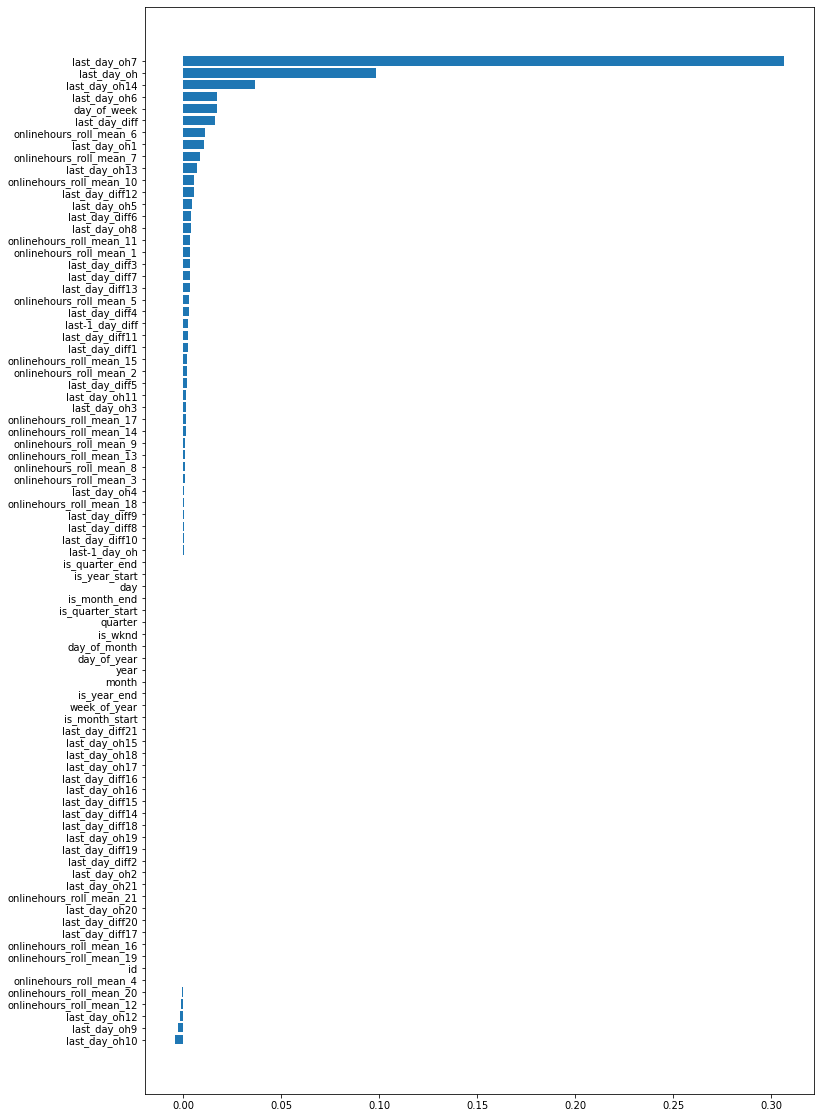

In [26]:
plt.figure(figsize = (12,20))
plt.barh(eli5_feature_importance.Features, eli5_feature_importance.Importance)

In [27]:
# feature selection based on permutation importance
feature_import = (eli5_feature_importance.sort_values(by = 'Importance', ascending = False)
                  .reset_index(drop = True).Features.tolist()[0:40]) 

In [33]:
with open("/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/interim/feature_import.csv", "w") as fp:
     json.dump(feature_import, fp)

In [28]:
train = df_copy[df_copy['day_of_month'] < 22]
test = df_copy[df_copy['day_of_month'] >= 22]


xtrain,xtest = train.drop(columns = ['id','date','online_hours']),test.drop(columns = ['id','date','online_hours'])
xtrain = xtrain[feature_import]
xtest = xtest[feature_import]
ytrain,ytest = train['online_hours'].values, test['online_hours'].values
    
model = LGBMRegressor(n_estimators = 1000)
model.fit(xtrain,ytrain)
preds = model.predict(xtest)
    
score = rmse(test_df.online_hours.tolist(),preds)

print('RMSE score: ', score)

RMSE score:  2.6607875682381312


In [29]:
xtrain.to_csv('/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/interim/xtrain.csv',
            index=False)
xtest.to_csv('/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/interim/xtest.csv',
            index=False)

np.save('/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/interim/ytrain.npy',
        ytrain) 
np.save('/Users/nadiiapoliakovska/Documents/Springboard/Users_active_time_prediction/data/interim/ytest.npy',
        ytest) 